#**Download Libraries**

In [1]:
# pip install gym stable-baselines3 yfinance
# pip install --upgrade "shimmy>=2.0"
# pip install --upgrade "stable-baselines3[extra]" "gymnasium" "shimmy" "torch
# pip install gymnasium
# pip cache purge
# pip install stable-baselines3[extra]
# pip install shimmy
# pip install yfinance gym stable-baselines3 matplotlib pandas
# pip install yfinance gym stable-baselines3 matplotlib pandas yfinance shimmy
# pip install alpha_vantage
# pip install stable-baselines3[extra] sb3-contrib



#**Fetch Data using Yahoo Finance**

In [2]:
'''
import yfinance as yf
import pandas as pd
from datetime import datetime

# Define the stock tickers and the period for which you want the data
tickers = ['AAPL', 'MSFT', 'GOOG', 'KO', 'PG', 'F', 'GE', 'T', 'XOM', 'CSCO', 'JNJ']
start_date = '2019-01-01'
end_date = '2023-12-31'
data = {}

# Fetch data for each ticker
for ticker in tickers:
    try:
        stock_data = yf.download(ticker, start=start_date, end=end_date)
        data[ticker] = stock_data
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

# Convert the data into a DataFrame
if data:
    stock_data = pd.concat(data, axis=1)
    stock_data.to_csv("yfinance_stock_data.csv")
    print(stock_data.head())
else:
    print("No data fetched.")
'''

'\nimport yfinance as yf\nimport pandas as pd\nfrom datetime import datetime\n\n# Define the stock tickers and the period for which you want the data\ntickers = [\'AAPL\', \'MSFT\', \'GOOG\', \'KO\', \'PG\', \'F\', \'GE\', \'T\', \'XOM\', \'CSCO\', \'JNJ\']\nstart_date = \'2019-01-01\'\nend_date = \'2023-12-31\'\ndata = {}\n\n# Fetch data for each ticker\nfor ticker in tickers:\n    try:\n        stock_data = yf.download(ticker, start=start_date, end=end_date)\n        data[ticker] = stock_data\n    except Exception as e:\n        print(f"Error fetching data for {ticker}: {e}")\n\n# Convert the data into a DataFrame\nif data:\n    stock_data = pd.concat(data, axis=1)\n    stock_data.to_csv("yfinance_stock_data.csv")\n    print(stock_data.head())\nelse:\n    print("No data fetched.")\n'

In [3]:
import pandas as pd

#stock_data = pd.read_csv("stock_data_1990_2024.csv", header=[0, 1, 2], index_col=0, parse_dates=True)
stock_data = pd.read_csv("etfs_data_2010_2024.csv", header=[0, 1, 2], index_col=0, parse_dates=True)

stock_data.head()

SPY                                                    IVV  \
Price           Close       High        Low       Open     Volume      Close   
Ticker            SPY        SPY        SPY        SPY        SPY        IVV   
Date                                                                           
2010-01-04  85.768448  85.813854  84.391067  85.041918  118944600  85.936852   
2010-01-05  85.995506  86.033349  85.405201  85.715493  111579900  86.186386   
2010-01-06  86.056046  86.267949  85.844142  85.912251  116074400  86.254448   
2010-01-07  86.419312  86.525263  85.654939  85.897116  131091100  86.632530   
2010-01-08  86.706871  86.744713  86.018184  86.192245  126402800  86.927437   

                                                      ...        EMB  \
Price            High        Low       Open   Volume  ...      Close   
Ticker            IVV        IVV        IVV      IVV  ...        EMB   
Date                                                  ...              
2010-01-04  86.004903  85.226065  85.271433  3574200  ...  49.949966   
2010-01-05  86.224190  85.634391  85.914170  2784100  ...  50.253784   
2010-01-06  86.458607  86.042726  86.118340  3912800  ...  50.322403   
2010-01-07  86.708144  85.861256  86.103225  2977600  ...  50.062679   
2010-01-08  86.935000  86.209093  86.375448  2887600  ...  50.121517   

                                                           VOE             \
Price            High        Low       Open  Volume      Close       High   
Ticker            EMB        EMB        EMB     EMB        VOE        VOE   
Date                                                                        
2010-01-04  49.949966  49.655942  49.856857  120500  32.666763  32.724810   
2010-01-05  50.268485  50.018562  50.087168   98700  32.768356  32.775611   
2010-01-06  50.351804  50.096984  50.278297  135300  33.000546  33.007803   
2010-01-07  50.234193  50.033274  50.170485   98300  33.239983  33.261750   
2010-01-08  50.224426  50.072514  50.121517  327900  33.348839  33.348839   

                                          
Price             Low       Open  Volume  
Ticker            VOE        VOE     VOE  
Date                                      
2010-01-04  32.449082  32.507129  143700  
2010-01-05  32.536163  32.674027  156100  
2010-01-06  32.753839  32.753839  172600  
2010-01-07  32.811875  32.956994   84800  
2010-01-08  33.087620  33.152925   70400  

[5 rows x 380 columns]

# **Trading Environment**

In [4]:
import gym
from gym import spaces
import numpy as np
import pandas as pd

# Constants for tax rates and holding period
SHORT_TERM_TAX_RATE = 0.20
LONG_TERM_TAX_RATE = 0.15
HOLDING_PERIOD_THRESHOLD = 365

class StockTradingEnv(gym.Env):
    def __init__(self, stock_data, initial_balance=10000, max_trade_pct=0.1, transaction_cost=0.001):
        super().__init__()

        if not isinstance(stock_data, pd.DataFrame):
            raise ValueError("stock_data must be a pandas DataFrame")

        self.original_df = stock_data
        self.stock_tickers = [str(col).split('_')[0] for col in stock_data.columns[::5]]
        self.dates = stock_data.index
        self.stock_data = stock_data.values

        self.n_steps = len(stock_data)
        self.n_stocks = len(stock_data.columns) // 5
        self.current_step = 0

        self.action_space = spaces.MultiDiscrete([3] * self.n_stocks)
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(len(stock_data.columns),), dtype=np.float32)

        self.initial_balance = initial_balance
        self.max_trade_pct = max_trade_pct
        self.transaction_cost = transaction_cost

        self.reset()

    def reset(self):
        self.current_step = 0
        self.current_balance = self.initial_balance
        self.current_portfolio = np.zeros(self.n_stocks)
        self.stock_purchase_prices = np.zeros(self.n_stocks)
        self.stock_purchase_times = np.zeros(self.n_stocks)
        self.total_trades = 0
        self.stock_profit = np.zeros(self.n_stocks)
        self.trade_logs = []
        self.portfolio_history = [self.initial_balance]
        return self._get_observation()

    def step(self, action):
        if self.current_step >= self.n_steps - 1:
            return self._get_observation(), 0, True, {}

        self._execute_trades(action)
        self.current_step += 1
        total_value = self._get_total_value()
        self.portfolio_history.append(total_value)
        reward = self._calculate_reward(total_value)
        done = self.current_step >= self.n_steps - 1
        return self._get_observation(), reward, done, {}

    def _get_observation(self):
        return np.array(self.stock_data[self.current_step], dtype=np.float32)

    def _get_total_value(self):
        prices = self.stock_data[self.current_step, ::5]
        return self.current_balance + np.sum(self.current_portfolio * prices)

        
    def _calculate_reward(self, total_value):
        # Bootstrap portfolio history if needed
        if len(self.portfolio_history) < 5:
            self.portfolio_history = [self.initial_balance] * 5

        # Portfolio-level signals
        profit = (total_value - self.initial_balance) / self.initial_balance

        returns = np.diff(self.portfolio_history[-5:]) / np.array(self.portfolio_history[-5:-1])
        rolling_sharpe = np.mean(returns) / (np.std(returns) + 1e-6) if len(returns) > 0 else 0

        growth_reward = (self.portfolio_history[-1] - np.mean(self.portfolio_history[-5:])) / self.initial_balance

        # Trade penalty
        trade_penalty = np.log1p(self.total_trades) * self.transaction_cost

        # === Trade-level net profit reward (from last executed sell) ===
        last_trade_profit = getattr(self, "last_trade_profit", 0)
        trade_reward = max(0, last_trade_profit / self.initial_balance)  # Only positive realized gains are rewarded

        # Reward composition
        reward = profit \
            + 0.01 * rolling_sharpe \
            + 0.5 * growth_reward \
            + 0.5 * trade_reward \
            - trade_penalty

        if self.current_step < 2:
            print(f"[DEBUG] Step={self.current_step} | Profit={profit:.4f}, Sharpe={rolling_sharpe:.4f}, Growth={growth_reward:.4f}, TradeReward={trade_reward:.4f}, Penalty={trade_penalty:.4f}, Total Reward={reward:.4f}")

        reward = np.clip(reward, -500, 500)
        return reward


    def _execute_trades(self, action):
        prices = self.stock_data[self.current_step, ::5]
        total_value = self._get_total_value()
        max_alloc = total_value * 0.15
        max_trade_amt = self.current_balance * self.max_trade_pct

        for i in range(self.n_stocks):
            act = action[i]
            price = prices[i]
            if act == 0:  # Buy
                trade_amt = min(max_trade_amt, max_alloc, self.current_balance)
                shares = int(trade_amt // price)
                if shares > 0:
                    self.current_balance -= shares * price * (1 + self.transaction_cost)
                    self.current_portfolio[i] += shares
                    self.stock_purchase_prices[i] = price
                    self.stock_purchase_times[i] = self.current_step
                    self.total_trades += 1
                    self._log_trade('Buy', i, shares, price)
            elif act == 2:  # Sell
                shares = int(self.current_portfolio[i])
                if shares > 0:
                    proceeds = shares * price * (1 - self.transaction_cost)
                    profit = shares * (price - self.stock_purchase_prices[i])
                    holding = self.current_step - self.stock_purchase_times[i]
                    tax = SHORT_TERM_TAX_RATE if holding < HOLDING_PERIOD_THRESHOLD else LONG_TERM_TAX_RATE
                    net = profit - profit * tax if profit > 0 else profit
                    self.stock_profit[i] += net
                    self.current_balance += proceeds
                    self.current_portfolio[i] -= shares
                    self.total_trades += 1
                    self._log_trade('Sell', i, shares, price, net, holding)

    def _log_trade(self, typ, idx, qty, price, profit=0, hold=0):
        self.trade_logs.append({
            'Stock_Ticker': self.stock_tickers[idx],
            'Trade_Type': typ,
            'Quantity': qty,
            'Price': price,
            'Date': self.dates[self.current_step],
            'Profit_Loss': round(profit, 2),
            'Holding_Period': hold
        })

    def save_trade_logs(self, filepath='logs.csv'):
        if not self.trade_logs:
            print("No trades to log.")
            return
        df = pd.DataFrame(self.trade_logs)
        df.to_csv(filepath, index=False)
        print(f"Trade logs saved to {filepath}")

    def render(self):
        print(f"Step: {self.current_step}, Balance: {self.current_balance}, Portfolio Value: {np.sum(self.current_portfolio * self.stock_data[self.current_step, ::5])}, Total Value: {self.current_balance + np.sum(self.current_portfolio * self.stock_data[self.current_step, ::5])}")


# **Enviroment Parameters**

In [5]:
# Define fixed environment parameters
initial_balance = 20000  # Set initial capital amount
max_trade_percentage = 0.1  # Max 10% of total capital per transaction
transaction_cost = 0.005  # Transaction cost per trade
top_n_stocks=5  # Number of top-ranked stocks to trade

# **Train PPO-LSTM Model**

In [6]:
from sb3_contrib import RecurrentPPO
from stable_baselines3 import PPO, A2C

# Create the environment
train_env = StockTradingEnv(
    stock_data, 
    initial_balance=initial_balance, 
    max_trade_pct=max_trade_percentage, 
    transaction_cost=transaction_cost
)


# Define models
ppo_model = PPO("MlpPolicy", train_env, verbose=0)
a2c_model = A2C("MlpPolicy", train_env, verbose=0)
lstm_model = RecurrentPPO("MlpLstmPolicy", train_env, verbose=0)

# Train each model
ppo_model.learn(total_timesteps=20000)
a2c_model.learn(total_timesteps=20000)
lstm_model.learn(total_timesteps=20000)

C:\Users\tinot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
C:\Users\tinot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


[DEBUG] Step=1 | Profit=-0.0033, Sharpe=0.0000, Growth=0.0000, TradeReward=0.0000, Penalty=0.0128, Total Reward=-0.0161
[DEBUG] Step=1 | Profit=-0.0025, Sharpe=0.0000, Growth=0.0000, TradeReward=0.0000, Penalty=0.0124, Total Reward=-0.0149
[DEBUG] Step=1 | Profit=-0.0034, Sharpe=0.0000, Growth=0.0000, TradeReward=0.0000, Penalty=0.0128, Total Reward=-0.0162
[DEBUG] Step=1 | Profit=-0.0018, Sharpe=0.0000, Growth=0.0000, TradeReward=0.0000, Penalty=0.0128, Total Reward=-0.0146
[DEBUG] Step=1 | Profit=-0.0042, Sharpe=0.0000, Growth=0.0000, TradeReward=0.0000, Penalty=0.0128, Total Reward=-0.0171
[DEBUG] Step=1 | Profit=-0.0050, Sharpe=0.0000, Growth=0.0000, TradeReward=0.0000, Penalty=0.0128, Total Reward=-0.0179
[DEBUG] Step=1 | Profit=-0.0035, Sharpe=0.0000, Growth=0.0000, TradeReward=0.0000, Penalty=0.0132, Total Reward=-0.0167
[DEBUG] Step=1 | Profit=-0.0032, Sharpe=0.0000, Growth=0.0000, TradeReward=0.0000, Penalty=0.0128, Total Reward=-0.0160
[DEBUG] Step=1 | Profit=-0.0044, Sharpe=

# **Evaluate Using All Stocks**

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def evaluate_trading_bot(models, model_names, test_env, benchmark_data=None, initial_investment=20000):
    results = []
    value_curves = {}

    for model, name in zip(models, model_names):
        print(f"\nEvaluating {name}...")
        obs = test_env.reset()
        total_rewards = []
        portfolio_values = []
        daily_returns = []

        for _ in range(test_env.n_steps):
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, _ = test_env.step(action)

            close_prices = obs[::5]
            total_value = test_env.current_balance + np.sum(test_env.current_portfolio * close_prices)
            portfolio_values.append(total_value)
            total_rewards.append(reward)

            if len(portfolio_values) > 1:
                daily_returns.append((portfolio_values[-1] - portfolio_values[-2]) / portfolio_values[-2])

            if done:
                break

        final_value = portfolio_values[-1]
        profit = final_value - initial_investment
        ret_pct = (profit / initial_investment) * 100
        sharpe_ratio = (np.mean(daily_returns) / (np.std(daily_returns) + 1e-6)) * np.sqrt(252)
        peak = np.maximum.accumulate(portfolio_values)
        drawdown = (peak - portfolio_values) / peak
        max_dd = np.max(drawdown) * 100

        results.append({
            'Model': name,
            'Final Value': final_value,
            'Return (%)': ret_pct,
            'Sharpe Ratio': sharpe_ratio,
            'Max Drawdown (%)': max_dd
        })
        value_curves[name] = portfolio_values

        # Reset the env for next model
        test_env.reset()

    # --- Plot: Portfolio value curves ---
    plt.figure(figsize=(14, 6))
    for name in model_names:
        plt.plot(value_curves[name], label=name)
    if benchmark_data is not None:
        plt.plot(benchmark_data, label="Benchmark (e.g., SPY)", linestyle="--")
    plt.title("Portfolio Value Over Time")
    plt.xlabel("Time Step")
    plt.ylabel("Portfolio Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Plot: Bar chart of metrics ---
    df_results = pd.DataFrame(results).set_index("Model")
    df_results[['Return (%)', 'Sharpe Ratio', 'Max Drawdown (%)']].plot(kind='bar', figsize=(14, 6), subplots=True, layout=(1, 3), legend=False, title=['Return %', 'Sharpe Ratio', 'Max Drawdown %'])
    plt.tight_layout()
    plt.show()

    print("\nModel Evaluation Summary:")
    display(df_results.round(2))
    return df_results


# **Split Data for Benchmarking**

In [8]:
# Get SPY data using slicing
spy_data = stock_data.loc[:, (slice(None), slice(None), 'SPY')]
spy_data.columns = spy_data.columns.droplevel(0)
spy_data

Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2010-01-04,85.768448,85.813854,84.391067,85.041918,118944600
2010-01-05,85.995506,86.033349,85.405201,85.715493,111579900
2010-01-06,86.056046,86.267949,85.844142,85.912251,116074400
2010-01-07,86.419312,86.525263,85.654939,85.897116,131091100
2010-01-08,86.706871,86.744713,86.018184,86.192245,126402800
...,...,...,...,...,...
2024-12-24,599.496582,599.536501,593.684050,594.272308,33160100
2024-12-26,599.536499,600.673034,596.286267,597.701991,41219100


In [9]:
spy_normalized = spy_data['Close'].values / spy_data['Close'].values[0] * 20000

# **Evaluate Training Data**


Evaluating PPO...
[DEBUG] Step=1 | Profit=-0.0041, Sharpe=0.0000, Growth=0.0000, TradeReward=0.0000, Penalty=0.0124, Total Reward=-0.0165

Evaluating A2C...
[DEBUG] Step=1 | Profit=-0.0036, Sharpe=0.0000, Growth=0.0000, TradeReward=0.0000, Penalty=0.0128, Total Reward=-0.0165

Evaluating PPO-LSTM...
[DEBUG] Step=1 | Profit=-0.0033, Sharpe=0.0000, Growth=0.0000, TradeReward=0.0000, Penalty=0.0124, Total Reward=-0.0157


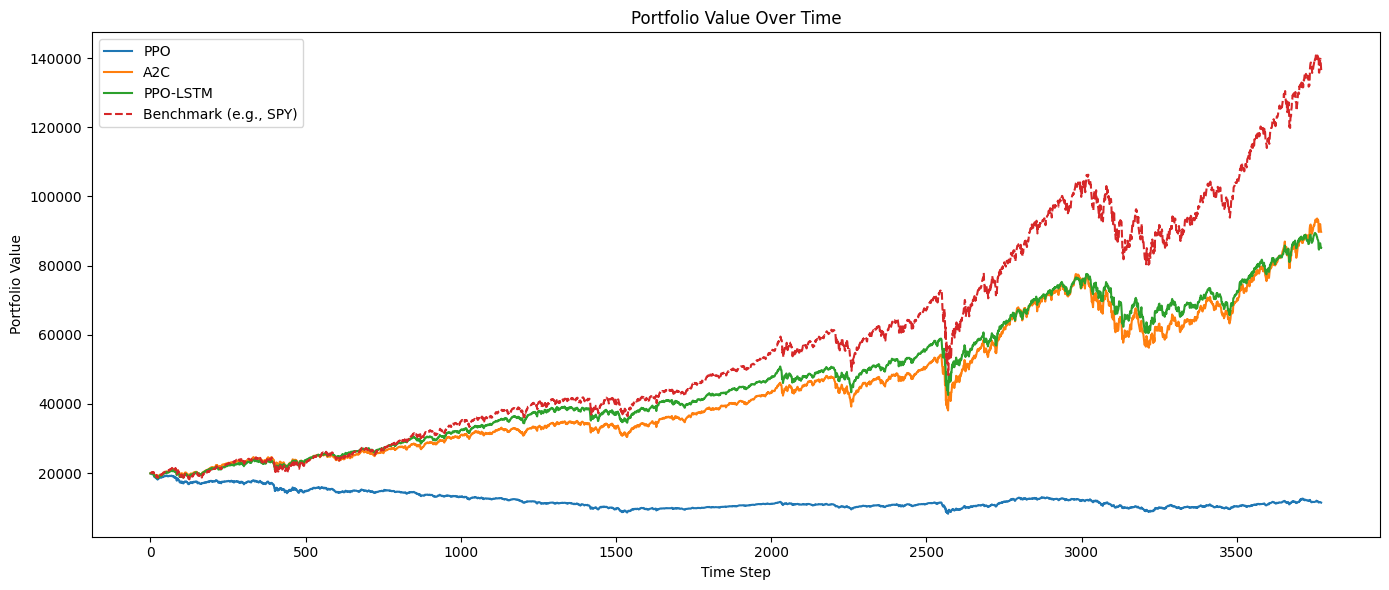

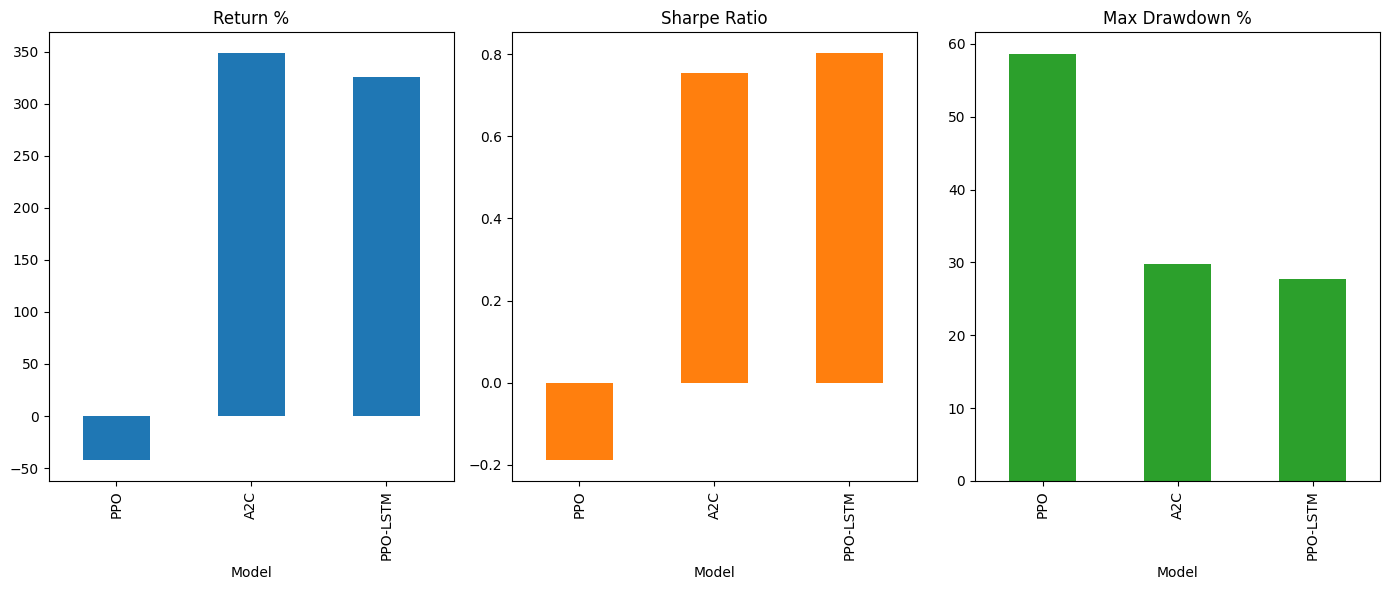


Model Evaluation Summary:


,Final Value,Return (%),Sharpe Ratio,Max Drawdown (%)
Model,,,,
PPO,11468.19,-42.66,-0.19,58.66
A2C,89770.65,348.85,0.75,29.74
PPO-LSTM,85135.81,325.68,0.80,27.68


,Final Value,Return (%),Sharpe Ratio,Max Drawdown (%)
Model,,,,
PPO,11468.192357,-42.659038,-0.189255,58.656687
A2C,89770.646356,348.853232,0.754597,29.739653
PPO-LSTM,85135.813409,325.679067,0.803696,27.684039


: 

In [ ]:
# Evaluate and compare
model_list = [ppo_model, a2c_model, lstm_model]
model_names = ["PPO", "A2C", "PPO-LSTM"]


evaluate_trading_bot(model_list, model_names, train_env, benchmark_data=spy_normalized)
